In [1]:
import pickle as pk
from imdb_indexer import word2index
import numpy as np
import pandas as pd
import itertools
import os
from functions import make_ngram, uptoNgram
import tqdm
import matplotlib.pyplot as plt
from bow import BagOfWords, test_model


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset

class IMDbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [3]:
ngram_dct = pk.load(open("ngram_dct.pk", "rb"))
train_label = pk.load(open("train_label.pk", "rb"))
test_label = pk.load(open("test_label.pk", "rb"))
val_label = pk.load(open("val_label.pk", "rb"))


In [4]:
#adam
val_acc_adam_ngram = []
val_curve_adam_ngram = []
ngram_list = [1,2,3,4]
for i in range(len(ngram_list)):
    ngram = ngram_list[i]
    train_features = ngram_dct['train_%s' %ngram]
    val_features = ngram_dct['val_%s' %ngram]
    test_features = ngram_dct['test_%s' %ngram]
    max_vocab_size = 50000
    PAD_IDX = 0
    UNK_IDX = 1
    all_train_features = list(itertools.chain.from_iterable(train_features))

    builder = word2index(PAD_IDX, UNK_IDX)
    #build vocab
    token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
    train_data_indices = builder.token2index_dataset(train_features)
    val_data_indices = builder.token2index_dataset(val_features)
    test_data_indices = builder.token2index_dataset(test_features)
    MAX_SENTENCE_LENGTH = 200

    # create pytorch dataloader
    BATCH_SIZE = 64
    train_dataset = IMDbDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = IMDbDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    learning_rate = 0.01
    learning_rate_decay = False
    num_epochs = 10
    emb_dim = 300
    model = BagOfWords(len(id2token), emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    val_acc_list = []
    for epoch in tqdm.trange(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            val_acc = test_model(val_loader, model)
            optimizer.step()

        val_acc_list.append(val_acc)
        if learning_rate_decay == True:
            scheduler.step(val_acc)

    val_curve_adam_ngram.append(val_acc_list)
    val_acc_adam_ngram.append(test_model(val_loader, model))
    print('finish vocab size %s, val_acc: %s' %(max_vocab_size, test_model(val_loader, model)))

100%|██████████| 10/10 [41:43<00:00, 250.35s/it]


finish vocab size 50000, val_acc: 84.96


100%|██████████| 10/10 [43:44<00:00, 262.49s/it]


finish vocab size 50000, val_acc: 85.42


100%|██████████| 10/10 [37:27<00:00, 224.73s/it]


finish vocab size 50000, val_acc: 80.48


100%|██████████| 10/10 [30:08<00:00, 180.85s/it]


finish vocab size 50000, val_acc: 74.26


Text(0.5,1,'spacy tokenization, adam optimization (lr=0.01), embedding_dim = 300, max_vocab = 50k')

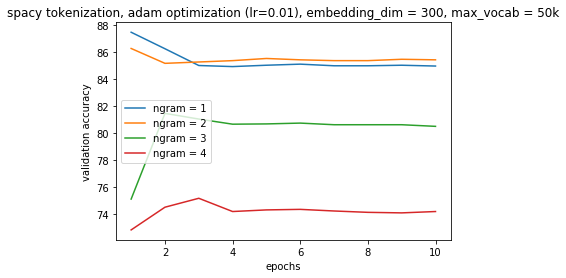

In [7]:
for i in range(len(val_curve_adam_ngram)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_ngram[i], label = 'ngram = %s' %(i+1))
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, adam optimization (lr=0.01), embedding_dim = 300, max_vocab = 50k')

In [11]:
val_acc_adam_ngram

[84.96, 85.42, 80.48, 74.26]

# 1+2-gram

In [14]:
upto2gram = pk.load(open("upto2gram.pk", "rb"))

In [15]:
train_features = upto2gram['train']
val_features = upto2gram['val']
test_features = upto2gram['test']

In [27]:
#setting max sentence length a 80^th percentile of all feature length for 1+2-gram for each sentence
feature_length = np.array([len(x) for x in train_features])
MAX_SENTENCE_LENGTH = int(np.percentile(feature_length, 80))
MAX_SENTENCE_LENGTH

669

In [28]:
max_vocab_size = 50000
PAD_IDX = 0
UNK_IDX = 1
all_train_features = list(itertools.chain.from_iterable(train_features))

builder = word2index(PAD_IDX, UNK_IDX)
#build vocab
token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
train_data_indices = builder.token2index_dataset(train_features)
val_data_indices = builder.token2index_dataset(val_features)
test_data_indices = builder.token2index_dataset(test_features)

# create pytorch dataloader
BATCH_SIZE = 64
train_dataset = IMDbDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

learning_rate = 0.01
learning_rate_decay = False
num_epochs = 10
emb_dim = 300
model = BagOfWords(len(id2token), emb_dim)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
val_acc_list = []
for epoch in tqdm.trange(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        val_acc = test_model(val_loader, model)
        optimizer.step()

    val_acc_list.append(val_acc)
    if learning_rate_decay == True:
        scheduler.step(val_acc)

val_curve_adam_ngram.append(val_acc_list)
val_acc_adam_ngram.append(test_model(val_loader, model))
print('finish, val_acc: %s' %(max_vocab_size, test_model(val_loader, model)))

100%|██████████| 10/10 [2:06:45<00:00, 760.57s/it] 


TypeError: not all arguments converted during string formatting

Text(0.5,1,'spacy tokenization, adam optimization (lr=0.01), embedding_dim = 300, max_vocab = 50k')

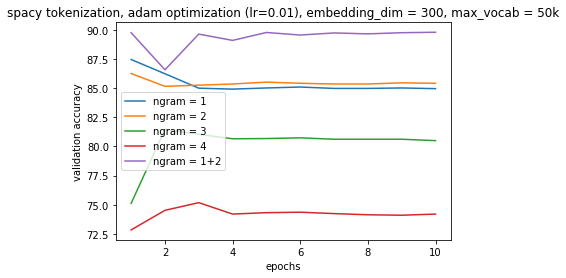

In [29]:
for i in range(len(val_curve_adam_ngram)-1):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_ngram[i], label = 'ngram = %s' %(i+1))
plt.plot(np.arange(1,num_epochs+1), val_curve_adam_ngram[-1], label = 'ngram = 1+2')    
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, adam optimization (lr=0.01), embedding_dim = 300, max_vocab = 50k')

In [30]:
C = pd.Index(["1-gram", "2-gram", "3-gram", "4-gram", "1+2-gram"], name="ngram")
I = pd.Index(["Adam"], name="optimizer")
df = pd.DataFrame(data=np.random.rand(1,5), index=I, columns=C)

df.iloc[0] = val_acc_adam_ngram

df

ngram,1-gram,2-gram,3-gram,4-gram,1+2-gram
optimizer,,,,,
Adam,84.96,85.42,80.48,74.26,89.8
